## Data
we have decided for now to work with much more simpler dataset called C50
### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import sys
sys.path.append("../")
from PythonCode.preprocess.preprocess import *
from PythonCode.preprocess.complexStyleFeatures import *
from PythonCode.preprocess.simpleStyleFeatures import *
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
stop_words = stopwords.words('english')
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint
DATA_PATH_TRAIN = "../Data/C50/C50train/"
DATA_PATH_TEST = "../Data/C50/C50test/"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yosef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = load_data("../Data/C50/C50train",50)
df

,author_name,book_name,book_text
0,AaronPressman,106247newsML.txt,The Internet may be overflowing with new techn...
1,AaronPressman,120600newsML.txt,The U.S. Postal Service announced Wednesday a ...
2,AaronPressman,120683newsML.txt,Elementary school students with access to the ...
3,AaronPressman,136958newsML.txt,An influential Internet organisation has backe...
4,AaronPressman,137498newsML.txt,An influential Internet organisation has backe...
...,...,...,...
2495,WilliamKazer,28223newsML.txt,China's central bank chief has said that infla...
2496,WilliamKazer,282935newsML.txt,"China ushered in 1997, a year it has hailed as..."
2497,WilliamKazer,287736newsML.txt,China issued tough new rules on the handling o...
2498,WilliamKazer,289747newsML.txt,China will avoid bold moves in tackling its ai...


In [11]:
def char_based_chunking(df: pd.DataFrame, chunk_size: int = 100) -> pd.DataFrame:
    rows = []
    for _, row in df.iterrows():
        chars = list(row[TEXT_COLUMN_LABEL])
        chunks = [''.join(chars[i: i + chunk_size]) for i in range(0, len(chars), chunk_size)]
        for chunk in chunks:
            tmp_row = row.copy()
            tmp_row[TEXT_COLUMN_LABEL] = chunk
            rows.append(tmp_row.copy())
    return pd.DataFrame(rows)

In [5]:
df["book_text"].swifter.apply(len).describe()

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1675: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


count    2500.000000
mean     3078.814000
std       829.001528
min       348.000000
25%      2597.750000
50%      3094.000000
75%      3508.000000
max      8575.000000
Name: book_text, dtype: float64

In [12]:
new_df = char_based_chunking(df,chunk_size=100)
new_df

,author_name,book_name,book_text
0,AaronPressman,106247newsML.txt,The Internet may be overflowing with new techn...
0,AaronPressman,106247newsML.txt,ioned variety.\nThe National Consumers League ...
0,AaronPressman,106247newsML.txt,"et was the pyramid scheme, in which early inve..."
0,AaronPressman,106247newsML.txt,"ter investors.\nThe league, a non-profit consu..."
0,AaronPressman,106247newsML.txt,set up on the world wide web in February calle...
...,...,...,...
2499,WilliamKazer,304402newsML.txt,ysts said Jiang was placating the Communist Pa...
2499,WilliamKazer,304402newsML.txt,"scheduled for later this year, a pivotal meeti..."
2499,WilliamKazer,304402newsML.txt,"ourse for the next five years.\n""By holding ti..."
2499,WilliamKazer,304402newsML.txt,"at he is the one to interpret Deng,"" said a Ch..."


In [16]:
new_lens = new_df["book_text"].swifter.apply(len)
new_lens.describe()

Pandas Apply:   0%|          | 0/78228 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\nanops.py:1675: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


count    78228.000000
mean        98.392328
std         10.245754
min          1.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: book_text, dtype: float64

In [25]:
new_df = new_df[new_lens > 30]

In [152]:
X,y = new_df["book_text"],new_df["author_name"]
mask = (pd.Series(y).isin(list(pd.Series(y).value_counts().sort_values()[::-1][:5].index)))
X = X[mask]
y = y[mask]
y = pd.Categorical(y).codes
X = X.reset_index().drop("index",axis=1)["book_text"]

In [155]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=42)

In [156]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
def preprocess(X_train,X_test):
    max_length = max(map(len, X_train))
    print(max_length)
    toknizer = Tokenizer(char_level=True, oov_token='@',num_words=None)
    toknizer.fit_on_texts(X_train)
    X_train = pad_sequences(toknizer.texts_to_sequences(X_train),maxlen=max_length,padding='post')
    X_test = pad_sequences(toknizer.texts_to_sequences(X_test),maxlen=max_length,padding='post')
    return X_train,X_test,toknizer

In [157]:
X_train,X_test,encoder = preprocess(X_train,X_test)

100


In [96]:
X_train.shape

(58085, 100)

<AxesSubplot:>

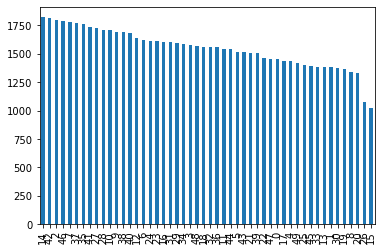

In [77]:
# weights = 1 - pd.Series(y).value_counts()/y.size
# weights = weights.to_dict()
# weights
pd.Series(y).value_counts().plot(kind="bar")

In [165]:
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Embedding
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Bidirectional(LSTM(70,recurrent_dropout=0.5),input_shape=(100,1)))
model.add(Dense(80, activation="relu"))
model.add(Dense(40, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 140)               40320     
_________________________________________________________________
dense_31 (Dense)             (None, 80)                11280     
_________________________________________________________________
dense_32 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_33 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_34 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 55        
Total params: 55,925
Trainable params: 55,925
Non-trainable params: 0
_________________________________________________

In [160]:
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

In [161]:
num_classes = pd.Series(y).unique().size
num_classes

5

In [162]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

In [163]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [167]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
history = model.fit(x=X_train, y=y_train, epochs=200, shuffle=True,
          batch_size=200, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/200
34/34 [==============================] - 13s 382ms/step - loss: 1.6094 - accuracy: 0.2015 - val_loss: 1.6097 - val_accuracy: 0.1897
Epoch 2/200
34/34 [==============================] - 13s 397ms/step - loss: 1.6094 - accuracy: 0.2015 - val_loss: 1.6098 - val_accuracy: 0.1897
Epoch 3/200
34/34 [==============================] - 14s 404ms/step - loss: 1.6094 - accuracy: 0.2015 - val_loss: 1.6098 - val_accuracy: 0.1897
Epoch 4/200
34/34 [==============================] - 14s 410ms/step - loss: 1.6094 - accuracy: 0.1984 - val_loss: 1.6098 - val_accuracy: 0.1897
Epoch 5/200
34/34 [==============================] - 14s 412ms/step - loss: 1.6094 - accuracy: 0.2015 - val_loss: 1.6098 - val_accuracy: 0.1897
Epoch 6/200
34/34 [==============================] - 14s 402ms/step - loss: 1.6094 - accuracy: 0.2015 - val_loss: 1.6098 - val_accuracy: 0.1897
Epoch 7/200
34/34 [==============================] - 14s 407ms/step - loss: 1.6094 - accuracy: 0.1958 - val_loss: 1.6098 - val_accuracy:

34/34 [==============================] - 16s 463ms/step - loss: 1.3519 - accuracy: 0.4117 - val_loss: 1.8300 - val_accuracy: 0.2412
Epoch 114/200
34/34 [==============================] - 16s 468ms/step - loss: 1.3419 - accuracy: 0.4115 - val_loss: 1.8357 - val_accuracy: 0.2408
Epoch 115/200
34/34 [==============================] - 16s 466ms/step - loss: 1.3332 - accuracy: 0.4201 - val_loss: 1.8467 - val_accuracy: 0.2363
Epoch 116/200
34/34 [==============================] - 16s 464ms/step - loss: 1.3196 - accuracy: 0.4288 - val_loss: 1.8417 - val_accuracy: 0.2443
Epoch 117/200
34/34 [==============================] - 16s 463ms/step - loss: 1.3138 - accuracy: 0.4334 - val_loss: 1.8551 - val_accuracy: 0.2328
Epoch 118/200
34/34 [==============================] - 15s 446ms/step - loss: 1.3129 - accuracy: 0.4226 - val_loss: 1.8495 - val_accuracy: 0.2417
Epoch 119/200
34/34 [==============================] - 15s 440ms/step - loss: 1.3046 - accuracy: 0.4382 - val_loss: 1.8925 - val_accuracy:

In [176]:
def load_and_pre(chunk_size,num_authors=5,min_char_len=30):
    # df = load_data("../Data/C50/C50train",50)
    new_df = char_based_chunking(df,chunk_size)
    new_lens = new_df["book_text"].swifter.apply(len)
    new_df = new_df[new_lens > min_char_len]
    X,y = new_df["book_text"],new_df["author_name"]
    mask = (pd.Series(y).isin(list(pd.Series(y).value_counts().sort_values()[::-1][:num_authors].index)))
    X = X[mask]
    y = y[mask]
    y = pd.Categorical(y).codes
    X = X.reset_index().drop("index",axis=1)["book_text"]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=42)
    toknizer = Tokenizer(char_level=True, oov_token='@',num_words=None)
    toknizer.fit_on_texts(X_train)
    X_train = pad_sequences(toknizer.texts_to_sequences(X_train),maxlen=chunk_size,padding='post')
    X_test = pad_sequences(toknizer.texts_to_sequences(X_test),maxlen=chunk_size,padding='post')
    X_train = np.expand_dims(X_train,axis=-1)
    X_test = np.expand_dims(X_test,axis=-1)
    num_classes = pd.Series(y).unique().size
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
    return X_train,X_test,y_train,y_test

In [177]:
X_train,X_test,y_train,y_test = load_and_pre(chunk_size=500,num_authors=5,min_char_len=30)

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/16630 [00:00<?, ?it/s]

In [178]:
X_train.shape

(1424, 500, 1)

In [179]:
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Embedding,Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Bidirectional(LSTM(50,recurrent_dropout=0.5),input_shape=(500,1)))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 100)               20800     
_________________________________________________________________
dense_41 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_44 (Dense)             (None, 10)              

In [171]:
X_train.shape

(6753, 9, 1)

In [180]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
history2 = model.fit(x=X_train, y=y_train, epochs=200, shuffle=True,
          batch_size=200, validation_data=(X_test, y_test),callbacks=[callback])

Epoch 1/200
8/8 [==============================] - 15s 2s/step - loss: 1.6145 - accuracy: 0.1980 - val_loss: 1.6089 - val_accuracy: 0.2021
Epoch 2/200
8/8 [==============================] - 15s 2s/step - loss: 1.6107 - accuracy: 0.2107 - val_loss: 1.6100 - val_accuracy: 0.1853
Epoch 3/200
8/8 [==============================] - 16s 2s/step - loss: 1.6142 - accuracy: 0.1938 - val_loss: 1.6107 - val_accuracy: 0.1747
Epoch 4/200
8/8 [==============================] - 16s 2s/step - loss: 1.6121 - accuracy: 0.2128 - val_loss: 1.6119 - val_accuracy: 0.1768
Epoch 5/200
8/8 [==============================] - 17s 2s/step - loss: 1.6092 - accuracy: 0.2177 - val_loss: 1.6135 - val_accuracy: 0.1768
Epoch 6/200
8/8 [==============================] - 17s 2s/step - loss: 1.6117 - accuracy: 0.1987 - val_loss: 1.6135 - val_accuracy: 0.1768
Epoch 7/200
8/8 [==============================] - 17s 2s/step - loss: 1.6084 - accuracy: 0.2058 - val_loss: 1.6113 - val_accuracy: 0.1768
Epoch 8/200
8/8 [==========

## Topic Exploration

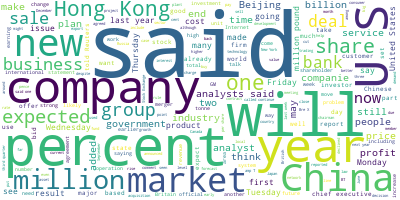

In [89]:
from wordcloud import WordCloud
long_string = ','.join(list(df['book_text'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [3]:
ignore_words = stop_words + ["said"]
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))# removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in ignore_words] for doc in texts]


In [4]:
data_words = list(sent_to_words(df["book_text"].values.tolist()))
data_words = remove_stopwords(data_words)
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

In [5]:
num_topics = 5
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"year" + 0.008*"would" + 0.007*"percent" + 0.006*"china" + '
  '0.005*"million" + 0.005*"new" + 0.004*"one" + 0.004*"also" + '
  '0.004*"company" + 0.004*"market"'),
 (1,
  '0.007*"percent" + 0.007*"would" + 0.007*"year" + 0.006*"million" + '
  '0.006*"company" + 0.005*"billion" + 0.005*"new" + 0.004*"market" + '
  '0.004*"china" + 0.004*"analysts"'),
 (2,
  '0.008*"percent" + 0.008*"million" + 0.006*"year" + 0.006*"would" + '
  '0.005*"market" + 0.005*"company" + 0.004*"one" + 0.004*"bank" + 0.004*"new" '
  '+ 0.004*"analysts"'),
 (3,
  '0.008*"would" + 0.006*"percent" + 0.006*"million" + 0.006*"year" + '
  '0.005*"new" + 0.005*"market" + 0.004*"china" + 0.004*"also" + '
  '0.004*"company" + 0.003*"one"'),
 (4,
  '0.007*"million" + 0.007*"year" + 0.006*"company" + 0.006*"percent" + '
  '0.006*"would" + 0.005*"billion" + 0.004*"new" + 0.004*"market" + '
  '0.004*"one" + 0.004*"analysts"')]


In [6]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, f'./ldavis_prepared_{str(num_topics)}.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008699 -0.002603       1        1  27.745696
4     -0.001262  0.006307       2        1  20.478496
0     -0.000538 -0.005813       3        1  19.797631
1      0.001925  0.004288       4        1  16.880901
3     -0.008824 -0.002179       5        1  15.097276, topic_info=           Term         Freq        Total Category  logprob  loglift
297       would  4920.000000  4920.000000  Default  30.0000  30.0000
5304       hong  1764.000000  1764.000000  Default  29.0000  29.0000
5307       kong  1752.000000  1752.000000  Default  28.0000  28.0000
722     billion  2929.000000  2929.000000  Default  27.0000  27.0000
82          new  3389.000000  3389.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
355   companies   234.030041  1835.711734   Topic5  -6.1480  -0.1691
761    expected   217.705963  1617.075578   Topic5  -6.2203  -0.1146
1090      first   221.928464  1917.725883   Topic5  -6.2011  -0.2659
1417      share   220.741891  1931.534683   Topic5  -6.2064  -0.2784
53        group   218.507913  1888.169597   Topic5  -6.2166  -0.2659

[456 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
12463      1  0.472522      aaa
15540      1  0.223812    abbey
15540      2  0.386584    abbey
15540      3  0.203465    abbey
15540      4  0.091559    abbey
...      ...       ...      ...
9001       5  0.126682   yellow
9002       1  0.557227  zollars
9002       3  0.185742  zollars
9002       4  0.185742  zollars
9002       5  0.185742  zollars

[1320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

In [19]:
new_topics = lda_model[corpus]
col_res = []
for i,topic in enumerate(new_topics):
    col_res.append(max(topic,key=lambda item:item[1])[0])
df["topic"] = pd.Series(col_res)

In [20]:
df

,author_name,book_name,book_text,topic
0,AaronPressman,106247newsML.txt,The Internet may be overflowing with new techn...,2
1,AaronPressman,120600newsML.txt,The U.S. Postal Service announced Wednesday a ...,2
2,AaronPressman,120683newsML.txt,Elementary school students with access to the ...,1
3,AaronPressman,136958newsML.txt,An influential Internet organisation has backe...,2
4,AaronPressman,137498newsML.txt,An influential Internet organisation has backe...,2
...,...,...,...,...
2495,WilliamKazer,28223newsML.txt,China's central bank chief has said that infla...,2
2496,WilliamKazer,282935newsML.txt,"China ushered in 1997, a year it has hailed as...",0
2497,WilliamKazer,287736newsML.txt,China issued tough new rules on the handling o...,0
2498,WilliamKazer,289747newsML.txt,China will avoid bold moves in tackling its ai...,0


## Preprocess

In [3]:
import functools
from PythonCode.preprocess.complexStyleFeatures import complex_style_features_extraction
from PythonCode.preprocess.simpleStyleFeatures import simple_style_features_extraction

x_train, x_test, y_train, y_test = preprocess_pipeline(data_path=DATA_PATH_TRAIN, number_of_authors=50,
                        repesention_handler=functools.partial(combine_features, [complex_style_features_extraction,simple_style_features_extraction]),
                        normalize=True, data_filter=chunking,save_path="./outputs/")

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

In [4]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,-0.118563,-0.752507,-0.781994,0.072664,-0.076077,-0.008775,-0.065658,0.311480,-0.600709,0.324654,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
1,-0.178434,0.411458,0.804171,-0.931365,-3.273332,-0.011953,0.948781,-0.468481,-0.475058,0.692027,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
2,-0.085087,-1.281812,-1.299012,0.424680,0.496727,-0.012066,-0.070691,-0.251571,0.649122,-0.467237,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
3,-0.139010,-1.392143,-1.322590,-0.182405,-0.112646,-0.008752,-0.607111,0.356369,-0.297904,-0.081784,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
4,-0.127869,0.608308,0.285449,0.592556,0.669814,-0.007128,0.238053,0.650483,0.121858,0.398676,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9384,-0.088960,-0.333581,-0.751996,1.894683,1.988131,-0.018209,-0.000276,-1.483578,0.702031,-0.662407,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
9385,-0.140260,0.329230,0.233577,0.077204,-0.218572,-0.008604,-0.093534,0.336188,-0.223286,0.133096,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
9386,-0.162219,0.124905,0.005464,0.000460,0.670173,-0.008736,-0.540770,0.454734,-0.475058,0.692027,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0
9387,-0.147624,0.795148,0.712632,-0.049681,-0.645631,-0.008471,1.421614,0.320948,-0.871432,0.245420,...,0.0,0.0,0.0,0.0,-0.010321,0.0,0.0,0.0,0.0,0.0


20it [04:06,  1.51it/s]C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
162it [04:32,  1.68s/it]


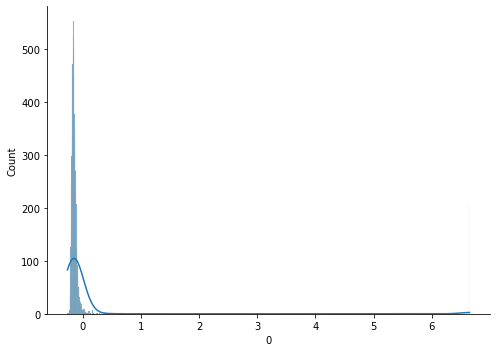

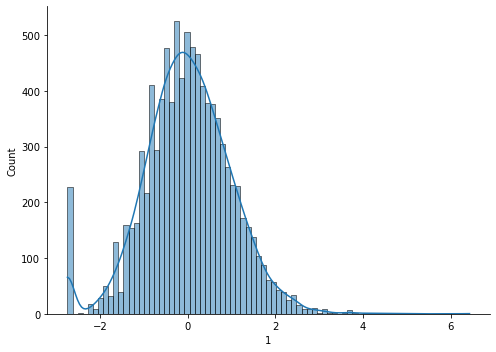

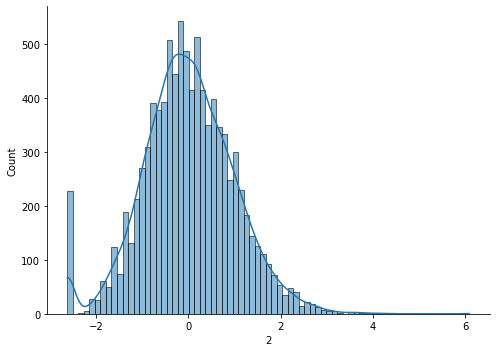

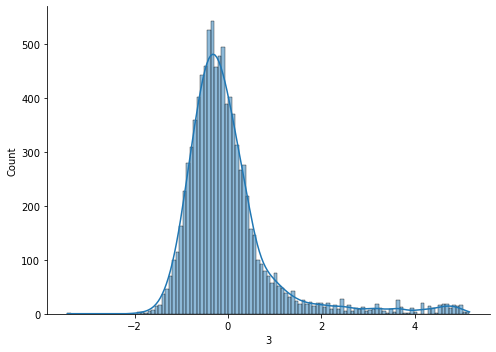

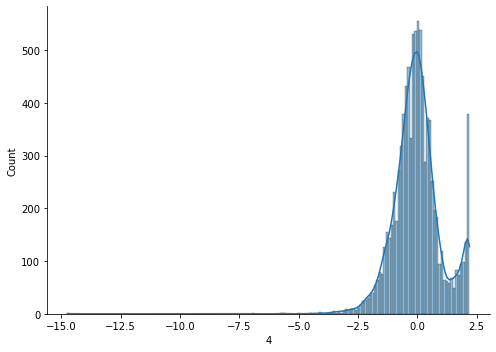

Error in callback <function flush_figures at 0x0000019F1AD1C160> (for post_execute):


KeyboardInterrupt: 

In [16]:
import math
from tqdm import tqdm

def plot_feature_dist(data: pd.DataFrame):
    columns = data.columns
    for i, col_name in tqdm(enumerate(columns)):
        try:
            sns.displot(x=col_name,data=data,kind="hist",kde=True,aspect=1.4)
        except Exception as e:
            print(e)
plot_feature_dist(x_train)

In [105]:
print("sentences number:\n")
print(df["book_text"].swifter.apply(lambda s: len(nltk.tokenize.sent_tokenize(s))).describe())
print("\nword(whitespace based) number:\n")
print(df["book_text"].swifter.apply(lambda s: len(s.split(" "))).describe())
print("\nword(word_tokanize based) number:\n")
print(df["book_text"].swifter.apply(lambda s: len(nltk.tokenize.word_tokenize(s))).describe())

sentences number:



Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

count    2500.00000
mean       21.55760
std         6.40224
min         2.00000
25%        18.00000
50%        21.00000
75%        25.00000
max        58.00000
Name: book_text, dtype: float64

word(whitespace based) number:



Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

count    2500.00000
mean      487.59120
std       131.77241
min        50.00000
25%       409.00000
50%       490.50000
75%       556.25000
max      1415.00000
Name: book_text, dtype: float64

word(word_tokanize based) number:



Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

count    2500.000000
mean      574.889600
std       156.444721
min        57.000000
25%       482.750000
50%       577.000000
75%       656.000000
max      1610.000000
Name: book_text, dtype: float64


In [49]:
import functools
from PythonCode.preprocess.complexStyleFeatures import complex_style_features_extraction
from PythonCode.preprocess.simpleStyleFeatures import simple_style_features_extraction

# x_train, x_test, y_train, y_test = preprocess_pipeline(data_path=DATA_PATH_TRAIN, number_of_authors=50,
#                         repesention_handler=complex_style_features_extraction,
#                         normalize=True, data_filter=chunking)

x_train, x_test, y_train, y_test = preprocess_pipeline(data_path=DATA_PATH_TRAIN, number_of_authors=50,
                        repesention_handler=functools.partial(combine_features, [complex_style_features_extraction,simple_style_features_extraction]),
                        normalize=True, data_filter=chunking,save_path="./outputs/")

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/9389 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4024 [00:00<?, ?it/s]

In [50]:
std_thr = 0.3
x_train = x_train.loc[:, x_train.std() > std_thr]
x_test = x_test[list(x_train.columns)]

In [51]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,214,216,217,222
0,-0.118563,-0.752507,-0.781994,0.072664,-0.076077,-0.008775,-0.065658,0.311480,-0.600709,0.324654,...,-0.391974,0.299958,-0.435186,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321
1,-0.178434,0.411458,0.804171,-0.931365,-3.273332,-0.011953,0.948781,-0.468481,-0.475058,0.692027,...,3.403275,-0.286098,-0.404019,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321
2,-0.085087,-1.281812,-1.299012,0.424680,0.496727,-0.012066,-0.070691,-0.251571,0.649122,-0.467237,...,0.748020,-0.598762,-0.123147,-0.172267,-0.143608,2.139479,-0.091516,-0.081923,-0.015998,-0.010321
3,-0.139010,-1.392143,-1.322590,-0.182405,-0.112646,-0.008752,-0.607111,0.356369,-0.297904,-0.081784,...,-0.208473,0.212438,-0.343699,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321
4,-0.127869,0.608308,0.285449,0.592556,0.669814,-0.007128,0.238053,0.650483,0.121858,0.398676,...,1.099784,-0.598762,-0.602056,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9384,-0.088960,-0.333581,-0.751996,1.894683,1.988131,-0.018209,-0.000276,-1.483578,0.702031,-0.662407,...,-1.822556,-0.598762,-0.137191,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321
9385,-0.140260,0.329230,0.233577,0.077204,-0.218572,-0.008604,-0.093534,0.336188,-0.223286,0.133096,...,0.625766,0.280144,0.072220,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321
9386,-0.162219,0.124905,0.005464,0.000460,0.670173,-0.008736,-0.540770,0.454734,-0.475058,0.692027,...,-0.759887,0.588065,-0.618613,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321
9387,-0.147624,0.795148,0.712632,-0.049681,-0.645631,-0.008471,1.421614,0.320948,-0.871432,0.245420,...,0.105934,-0.060310,-0.347193,-0.172267,-0.143608,-0.200131,-0.091516,-0.081923,-0.015998,-0.010321


## Models

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import pickle

classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(5),
    "Xgboost": XGBClassifier(n_estimators=100,learning_rate=0.001,verbosity=3,n_jobs=8,random_state=93,max_depth=10),
    "RBF SVM": SVC(gamma=2, C=1),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(max_depth=40),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=100, max_features=10),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
}
for name,classifier in classifiers.items():
    print(f"========== {name} ===========")
    try:
        classifier.fit(x_train,y_train)
        y_pred = classifier.predict(x_test)
        print(classification_report(y_test,y_pred))
        with open(f'{name}.pkl', 'wb') as file:
            pickle.dump(classifier, file)
    except Exception as e:
        print(e)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.metrics import Recall,Precision
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(120,activation="relu",input_shape=(162,)))
model.add(Dense(80,activation="relu"))
model.add(Dense(40,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer=Adam(0.003),metrics=['accuracy',Recall(),Precision()])
model.summary()

In [43]:
x_train.shape

(9389, 11)

In [ ]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(x_train, y_train, epochs=1000,validation_data=(x_test, y_test),callbacks=[callback])

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)